# 1) Download the Price Data via an API

In [165]:
# Remote data access for pandas
import pandas_datareader as webreader
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as col 
import matplotlib.cm as cm 
#from matplotlib import cm
import numpy as np 
from math import log, exp 
from datetime import date, timedelta, datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit

# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2012-09-16'

# Getting S&P500 quotes
stockname = 'BTC-USD'
symbol = 'BTC-USD'
df1 = webreader.DataReader(symbol, start=date_start, end=date_today, data_source="yahoo")

# Taking a look at the shape of the dataset
df1 = df1.filter(['Close'])

# Load earlier data from CSV
df2 = pd.read_csv('C:/Users/Flo/relataly-python-tutorials/data/CryptoPrices/bitcoin_price_daily_2010-2018.csv') 
df2_filter = df2.loc[(df2['btc_market_price'] > 0) & (df2['Date'] < '2014-09-16 00:00:00')]
Dates = pd.to_datetime(df2_filter['Date'], format='%Y-%m-%d', errors='ignore')
df2_filter = df2_filter.set_index(Dates).filter(['btc_market_price']).rename(columns={"btc_market_price": "Close"})

# Concatenate the two DataFrames to create the whole historic price range
frames=[df2_filter, df1]
result = pd.concat(frames)
df = result.copy()
df

,Close
Date,
2010-08-17,0.076900
2010-08-18,0.074000
2010-08-19,0.068800
2010-08-20,0.066700
2010-08-21,0.066899
...,...
2021-02-11,47909.332031
2021-02-12,47504.851562
2021-02-14,48717.289062


# 2) Calculate Logarithmic Regression and Risk Level

In [166]:
halving_dates = ['2009-03-01', '2012-11-28', '2016-07-09', '2020-05-11', '2024-06-01', '2028-06-01', '2032-06-01']

# function that converts a given set of indicator values to colors
def get_colors(ind, colormap):
    norm = col.Normalize(vmin=ind.min(), vmax=ind.max())
    colorlist = [list(colormap(norm(i))) for i in ind]
    return colorlist

# Calculate Days to Next Halving Date For Each Date
def get_days_to_halving(df):
    s = pd.to_datetime(df.index[1])
    day_diff_list = []
    for i in range(0, len(df)):
        for s in halving_dates:
            day_diff = datetime.strptime(s, '%Y-%m-%d').date() - df.index[i].date()
            if(day_diff.days >= 0):
                day_diff_list.append(day_diff.days)
                break
    return day_diff_list

def func(x, a, b, c):
    return a*np.log10(x + c) + b

x = [x for x in range(len(df))]
y = np.log(np.array(df['Close']))
popt, pcov = curve_fit(func, x, y)
df['log_reg'] =  func(np.array([x for x in range(len(df))]), *popt)

In [175]:
# --> risk_level
df['risk_level'] = np.log(df['Close'] / df['log_reg'])
y = df['risk_level']

# Convert to Colormap     
cmap = plt.get_cmap('plasma')
df['risk_level_colors'] = get_colors(y, cmap)

# 3) Print Logarithmic Chart color Coded by Days to Next Halving

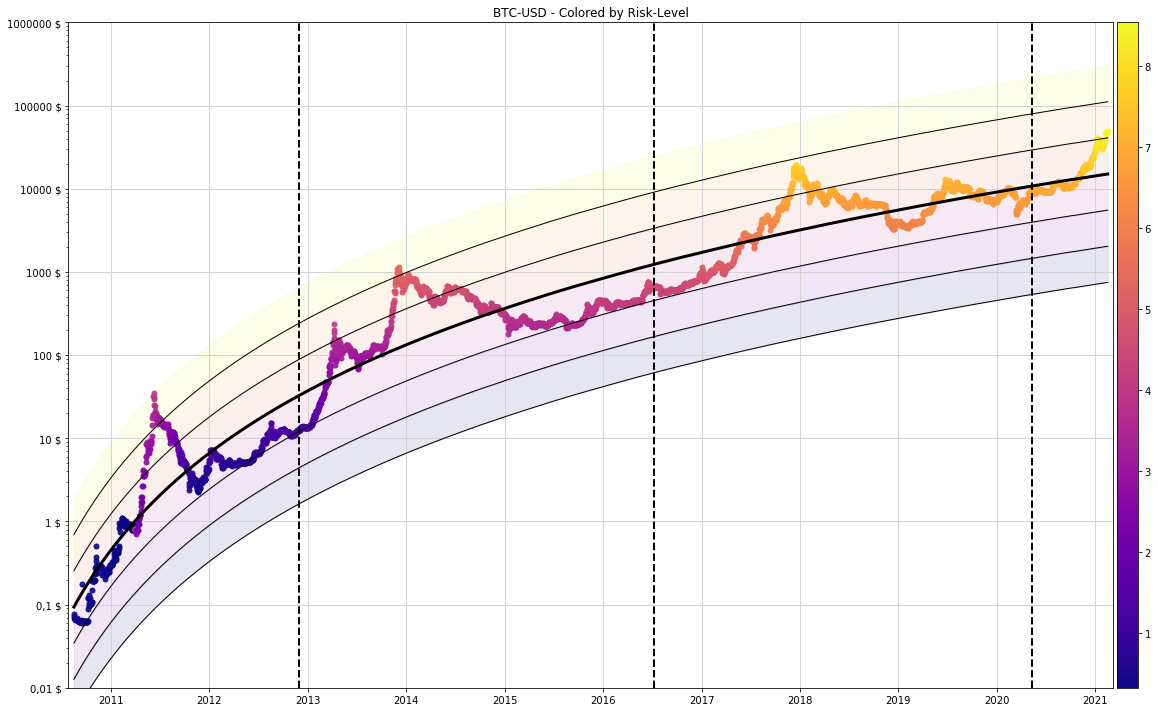

In [178]:
def defineBar(s, ax, cmap):
    vmin= s.min()
    vmax = s.max()
    m = cm.ScalarMappable(cmap=cmap, norm=col.Normalize(vmin=vmin,vmax=vmax))
    m.set_array([(x-vmin)/(vmax-vmin) for x in s.values])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    return cax, m

def draw_points(ax, y, z):
    # draw points
    for i in range(len(df)):
        ax.plot(x[i], np.array(y[i]), 'o',  color=z[i], alpha = 0.9, markersize=5)

# setup the data for the price chart
pd.plotting.register_matplotlib_converters()
fig, ax = plt.subplots(figsize=(16, 10), sharex=False)

x = df.index
y = df['Close']
z = df['risk_level_colors']
w = df['log_reg']

draw_points(ax, y, z)

bandrange = range(-2, 4)
colors = iter(plt.get_cmap('plasma')(np.linspace(0, 1, len(bandrange))))

# plot the log regression line
for i in bandrange:
    plt.plot(x, np.exp(w + i - 1), color='black', linewidth=1)
    plt.fill_between(x, np.exp(w + i - 1), np.exp(w + i), alpha=0.1, color=next(colors))
plt.plot(x, np.exp(w), color='black', linewidth=3)
    
ax.tick_params(axis='y', labelcolor='black')
plt.xlim([min(x) - timedelta(days=20), max(x) + timedelta(days=20)])
plt.ylim(0.01, 1000000)
plt.title('BTC-USD - Colored by Risk-Level')
plt.yscale('log')
plt.yticks([0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000], ['0,01 $', '0,1 $', '1 $', '10 $', '100 $', '1000 $', '10000 $', '100000 $', '1000000 $'])
plt.grid(color='lightgrey', linestyle='-', linewidth=1)
plt.tight_layout()


# add halving dates as vertical lines
for s in halving_dates:
    plt.axvline(x=datetime.strptime(s, '%Y-%m-%d').date(), color = 'black', linewidth=2, linestyle='dashed')

# plot the color bar
cax, m = defineBar(df['risk_level'], ax, 'plasma')
fig.colorbar(m, cax=cax)
plt.show()